<a href="https://colab.research.google.com/github/abdishifa234/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [74]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [75]:
#lets arrange and merge train,test submission datasets
import pandas as pd

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [76]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

In [77]:
# Split training set into train & val sets
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [78]:
#define a function that rangles all the 3 datasets
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, ladef wrangle(X):titude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year','gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()

    #creat water per person and population per year

    X['water/person'] = X['amount_tsh'] / X['population']

    X['pop/year'] = X['population'] / X['year_recorded']

    
    # return the wrangled dataframe
    return X


# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [79]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

###Plot a confusion matrix for your Tanzania Waterpumps model.

In [101]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8123737373737374


In [81]:
!pip install scikit-plot

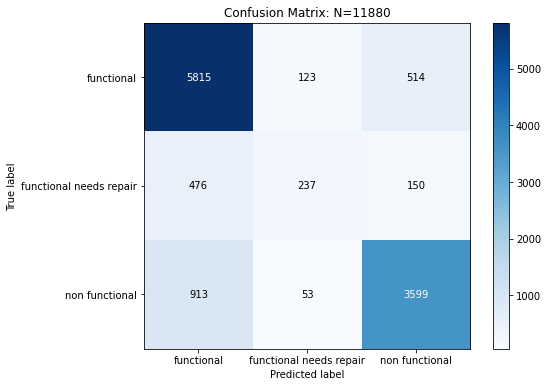

In [82]:
#plotting confusion matrix water pump prediction
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_val, y_pred,
                      figsize=(8,6),
                      title=f'Confusion Matrix: N={len(y_val)}',
                      normalize=False);

###How many **correct predictions** were made?

In [83]:
correct_predictions =5815 + 237 + 3599
correct_predictions

9651

### How many **total predictions** were made?

In [84]:
total_predictions=5815+123+514+476+237+150+913+53+3599
total_predictions

11880

#### What was the **classification accuracy**?

In [85]:
#manual calculation for classification accuracy
classification_accuracy=correct_predictions/total_predictions
classification_accuracy

0.8123737373737374

In [86]:
#check for accuracy
accuracy_score(y_val, y_pred)

0.8123737373737374

### Use classification metrics: **precision, recall**

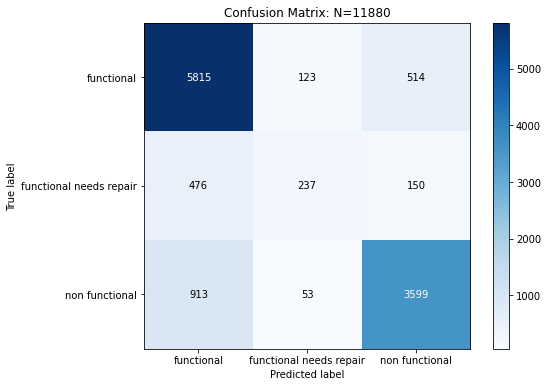

In [87]:
#lets display the confusion matrix here
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_val, y_pred,
                      figsize=(8,6),
                      title=f'Confusion Matrix: N={len(y_val)}',
                      normalize=False);

###How many **correct predictions of "non functional"?**

In [88]:
correct_predictions_nonfunctional = 3599

### How many **total predictions of "non functional"?**

In [89]:
total_predictions_nonfunctional=3599+150+514
total_predictions_nonfunctional

4263

### What's the **precision for "non functional"?**

In [90]:
precision=correct_predictions_nonfunctional / total_predictions_nonfunctional
precision

0.8442411447337556

### How many **actual "non functional" waterpumps?**

In [91]:
actual_nonfunctional = 913 + 53 + 3599
actual_nonfunctional

4565

### What's the **recall for "non functional"?**

In [92]:
recall_for_non_functional=correct_predictions_nonfunctional / actual_nonfunctional
recall_for_non_functional

0.7883899233296824

In [93]:
#lets use sklearn classification report metrix
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.57      0.27      0.37       863
         non functional       0.84      0.79      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



###Understanding the relationships between **precision, recall, thresholds, and predicted probabilities**

In [66]:
#NOT necessary to repeat class codes again and again,thank you our beloved Team leader!!!

In [94]:
#  Kaggle submission 
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission_confusion_matrix_1.csv', index=False)